## DRL 코드입니다.
* 저는 이 코드와 제가 만든 환경을 가지고 학습을 했지만, 실제로는 OMNeT++와 이 이 코드를 연동시켜주셔야 합니다.
* 그러므로 제가 만든 환경 코드는 이해하실 필요가 없습니다. 이 코드의 DNN 구조와, 환경과 상호작용하는 인터페이스 부분만 참고해주시면 될 듯 합니다.
* main 부분은 아키텍처 설명한 ppt를 보시고 새로 짜시는게 더 빠를 수 있습니다.
* DQN based가 아닌, Policy gradient based인 actor-critic을 쓰고자 합니다(많은 스케줄링 관련 논문에서 actor-critic 사용. 또한 DQN은 규모가 좀 커지면 학습 힘들다고 알고 있음).
* actor-critic 알고리즘은 다양합니다. 저희는 A3C 혹은 PPO를 쓸 것 같습니다. 각 알고리즘에 대해선 논문을 읽어보시거나 검색하셔서 이해해주시면 될 것 같습니다.
* actor network로 GNN(Graph Neural Network)를 사용합니다. Pytorch geometric library에서 다양한 GNN 모듈을 제공합니다. 저희는 Dynamic edge-conditioned GNN을 씁니다.
* Dynamic edge-conditioned GNN : https://arxiv.org/abs/1704.02901
* 코드 기반 : https://github.com/seungeunrho/minimalRL/blob/master/ppo.py
* GNN 예제 : https://baeseongsu.github.io/posts/pytorch-geometric-introduction/
* GNN 배치 단위 inference 하는법 : https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html
* 지금 이 코드는 돌아가긴 하지만, 학습이 제대로 안되는 상황입니다. 모든 state에 대해서 한 액션으로 거의 모든 확률이 쏠려버리게끔 학습이 되는데, 원인은 찾지 못했습니다. 아마 제가 만든 환경에 문제가 있을 수도 있고, 학습 자체를 더 튜닝해야 될 수도 있습니다.

In [22]:
import import_ipynb
from library import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch_geometric.nn import NNConv, global_mean_pool, GraphUNet
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np
import math
from matplotlib.pyplot import figure

%matplotlib inline

In [23]:
learning_rate   = 0.001
gamma           = 0.95
entropy_weight  = 0.1
'''
entropy_weight : loss함수에 entropy라는 걸 더해주는 테크닉에서의 weight입니다.
이 기법은 A3C 논문에 나와있으며, 쓰는 이유는 exploration을 촉진하기 위해서입니다.
각 액션을 취할 확률을 거의 균등하게끔 업데이트해줌으로써 다양한 액션을 해볼 기회가 많아집니다.
actor-critic에서 이 기법으로 인한 성능 개선이 매우 효과적인 것으로 알고있으므로, 적용해주시면 좋을 듯 합니다.
'''
lmbda         = 0.95
eps_clip      = 0.1
'''
위 두 인자는 PPO에서 씁니다.
'''

loss_coef = 0.5

node_feature_num = 100
queue_feature_num = 100

In [24]:
class actor_network(nn.Module):
    def __init__(self):
        super(actor_network, self).__init__()
        self.replay_memory = []

        self.pi_graph_u_net = GraphUNet(node_feature_num, 20, node_feature_num, 4, 0.9)

        self.pi_backbone = nn.Sequential(
            nn.Linear(200, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        # prob_fc : 각 액션에 대한 확률.
        self.pi_prob_fc = nn.Linear(64, 5)
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
              
        
    # policy DNN
    def pi(self, state):
        data, job_waiting_feature = state # data = graph data
        job_waiting_feature = job_waiting_feature.view(1, 100)
        node_feature, link_feature, adjacency = data.x, data.edge_attr, data.edge_index
        """
        node_feature = F.relu(self.conv1(node_feature, adjacency, link_feature))
        node_feature = F.relu(self.conv2(node_feature, adjacency, link_feature))
        #node_feature = F.relu(self.conv3(node_feature, adjacency, link_feature))
        readout = global_mean_pool(node_feature, data.batch) # 모든 노드의 feature를 평균내서 하나의 벡터로 만들어주기.
        """

        node_feature = self.pi_graph_u_net(node_feature, adjacency)
        readout = global_mean_pool(node_feature, data.batch)
        #print("readout", readout.shape)
        #print("job_waiting_feature", job_waiting_feature.shape)
        concat = torch.cat([readout, job_waiting_feature], dim=1) # 여기에 job waiting 벡터 붙이기.

        feature_extract = self.pi_backbone(concat)

        output = self.pi_prob_fc(feature_extract)
        return output     

    def put_data(self, transition):
        self.data.append(transition)
        
    
    # make_batch, train_net은 맨 위에 코드 기반 링크와 거의 동일합니다.
        
    def make_batch(self):
        network_lst, job_waiting_lst, a_lst, r_lst, next_network_lst, next_job_waiting_lst = [], [], [], [], [], []
        sampled_memory = random.sample(self.replay_memory, 32)
        
        #print("sampled_memory", sampled_memory)

        for transition in sampled_memory:
            # print("transition", transition)
            network, job_waiting, a, r, next_network, next_job_waiting = transition

            network_lst.append(network)
            job_waiting_lst.append(job_waiting)
            a_lst.append([a])
            r_lst.append([r])
            next_network_lst.append(next_network)
            next_job_waiting_lst.append(next_job_waiting)
            
        # gnn sample을 배치단위로 inference하려면 이렇게 묶어줘야 함.
        
        return network_lst, torch.tensor(job_waiting_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.int64)\
    , torch.tensor(r_lst, dtype=torch.float), next_network_lst, torch.tensor(next_job_waiting_lst, dtype=torch.float)
    
    
    def train_net(self, target_model):
        
        for i in range(5):
            network_batch, job_waiting, a, r, next_network_batch, next_job_waiting = self.make_batch()
            for j in range(len(network_batch)):
                #print(network_batch[j])

                q_out = self.pi([network_batch[j], job_waiting[j]])[0]
                
                q_a = q_out[a]
                
                max_q_prime = torch.max(target_model.pi([network_batch[j], job_waiting[j]])[0])
                #print("max_q_prime", max_q_prime)
                target = r + gamma * max_q_prime
                loss = F.smooth_l1_loss(q_a, target)
                
                #print("loss", loss)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
       

In [25]:
class target_network(nn.Module):
    def __init__(self):
        super(target_network, self).__init__()
        self.data = []
        self.replay_memory = []

        self.pi_graph_u_net = GraphUNet(node_feature_num, 20, node_feature_num, 4, 0.9)

        self.pi_backbone = nn.Sequential(
            nn.Linear(200, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        # prob_fc : 각 액션에 대한 확률.
        self.pi_prob_fc = nn.Linear(64, 5)
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
              
        
    # policy DNN
    def pi(self, state):
        data, job_waiting_feature = state # data = graph data
        job_waiting_feature = job_waiting_feature.view(1, 100)
        node_feature, link_feature, adjacency = data.x, data.edge_attr, data.edge_index
        """
        node_feature = F.relu(self.conv1(node_feature, adjacency, link_feature))
        node_feature = F.relu(self.conv2(node_feature, adjacency, link_feature))
        #node_feature = F.relu(self.conv3(node_feature, adjacency, link_feature))
        readout = global_mean_pool(node_feature, data.batch) # 모든 노드의 feature를 평균내서 하나의 벡터로 만들어주기.
        """
        node_feature = self.pi_graph_u_net(node_feature, adjacency)
        readout = global_mean_pool(node_feature, data.batch)
        #print("readout", readout.shape)
        #print("job_waiting_feature", job_waiting_feature.shape)
        concat = torch.cat([readout, job_waiting_feature], dim=1) # 여기에 job waiting 벡터 붙이기.

        feature_extract = self.pi_backbone(concat)

        output = self.pi_prob_fc(feature_extract)
        return output     

0.97
0.97


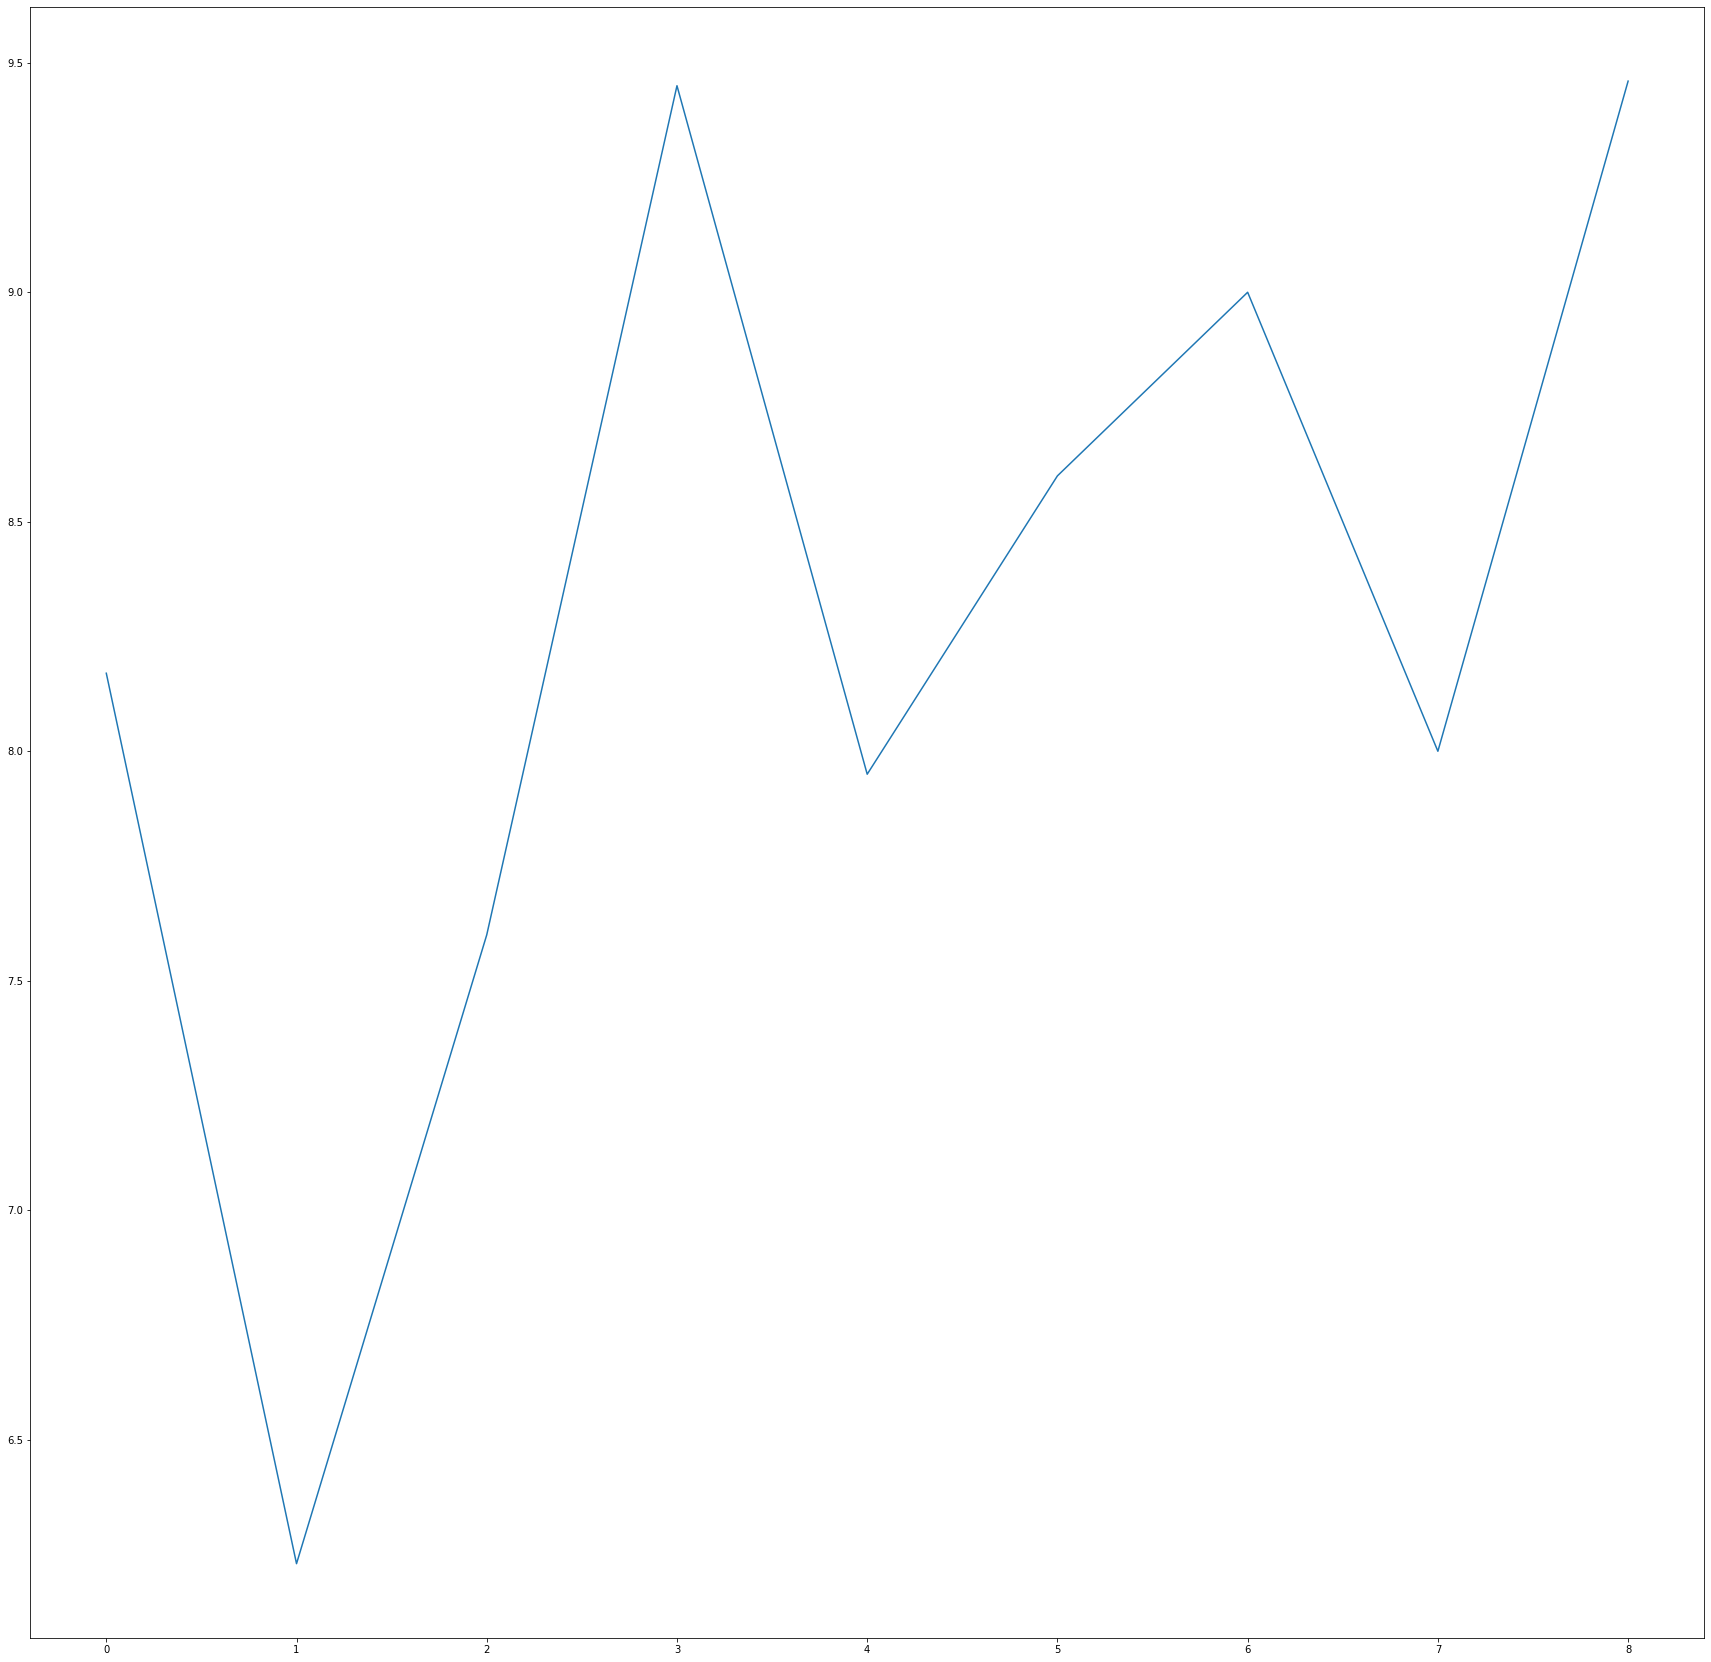

tensor([-0.0017, -0.1166,  0.0143, -0.0692,  0.0909],
       grad_fn=<SelectBackward0>)
max_q_prime tensor(0.0909, grad_fn=<MaxBackward1>)
loss tensor(8.0207, grad_fn=<SmoothL1LossBackward0>)
tensor([ 0.0438, -0.1850,  0.0108, -0.0673,  0.1428],
       grad_fn=<SelectBackward0>)
max_q_prime tensor(0.1373, grad_fn=<MaxBackward1>)
loss tensor(8.0573, grad_fn=<SmoothL1LossBackward0>)
tensor([ 0.0064, -0.1764,  0.0035, -0.0555,  0.1294],
       grad_fn=<SelectBackward0>)
max_q_prime tensor(0.1099, grad_fn=<MaxBackward1>)
loss tensor(8.0395, grad_fn=<SmoothL1LossBackward0>)
tensor([ 0.0565, -0.1247,  0.0164, -0.0602,  0.1252],
       grad_fn=<SelectBackward0>)
max_q_prime tensor(0.0995, grad_fn=<MaxBackward1>)
loss tensor(8.0088, grad_fn=<SmoothL1LossBackward0>)
tensor([ 0.0477, -0.0947,  0.0328, -0.0316,  0.1384],
       grad_fn=<SelectBackward0>)
max_q_prime tensor(0.1002, grad_fn=<MaxBackward1>)
loss tensor(7.9936, grad_fn=<SmoothL1LossBackward0>)
tensor([ 0.0625, -0.0836,  0.0377, -0.03

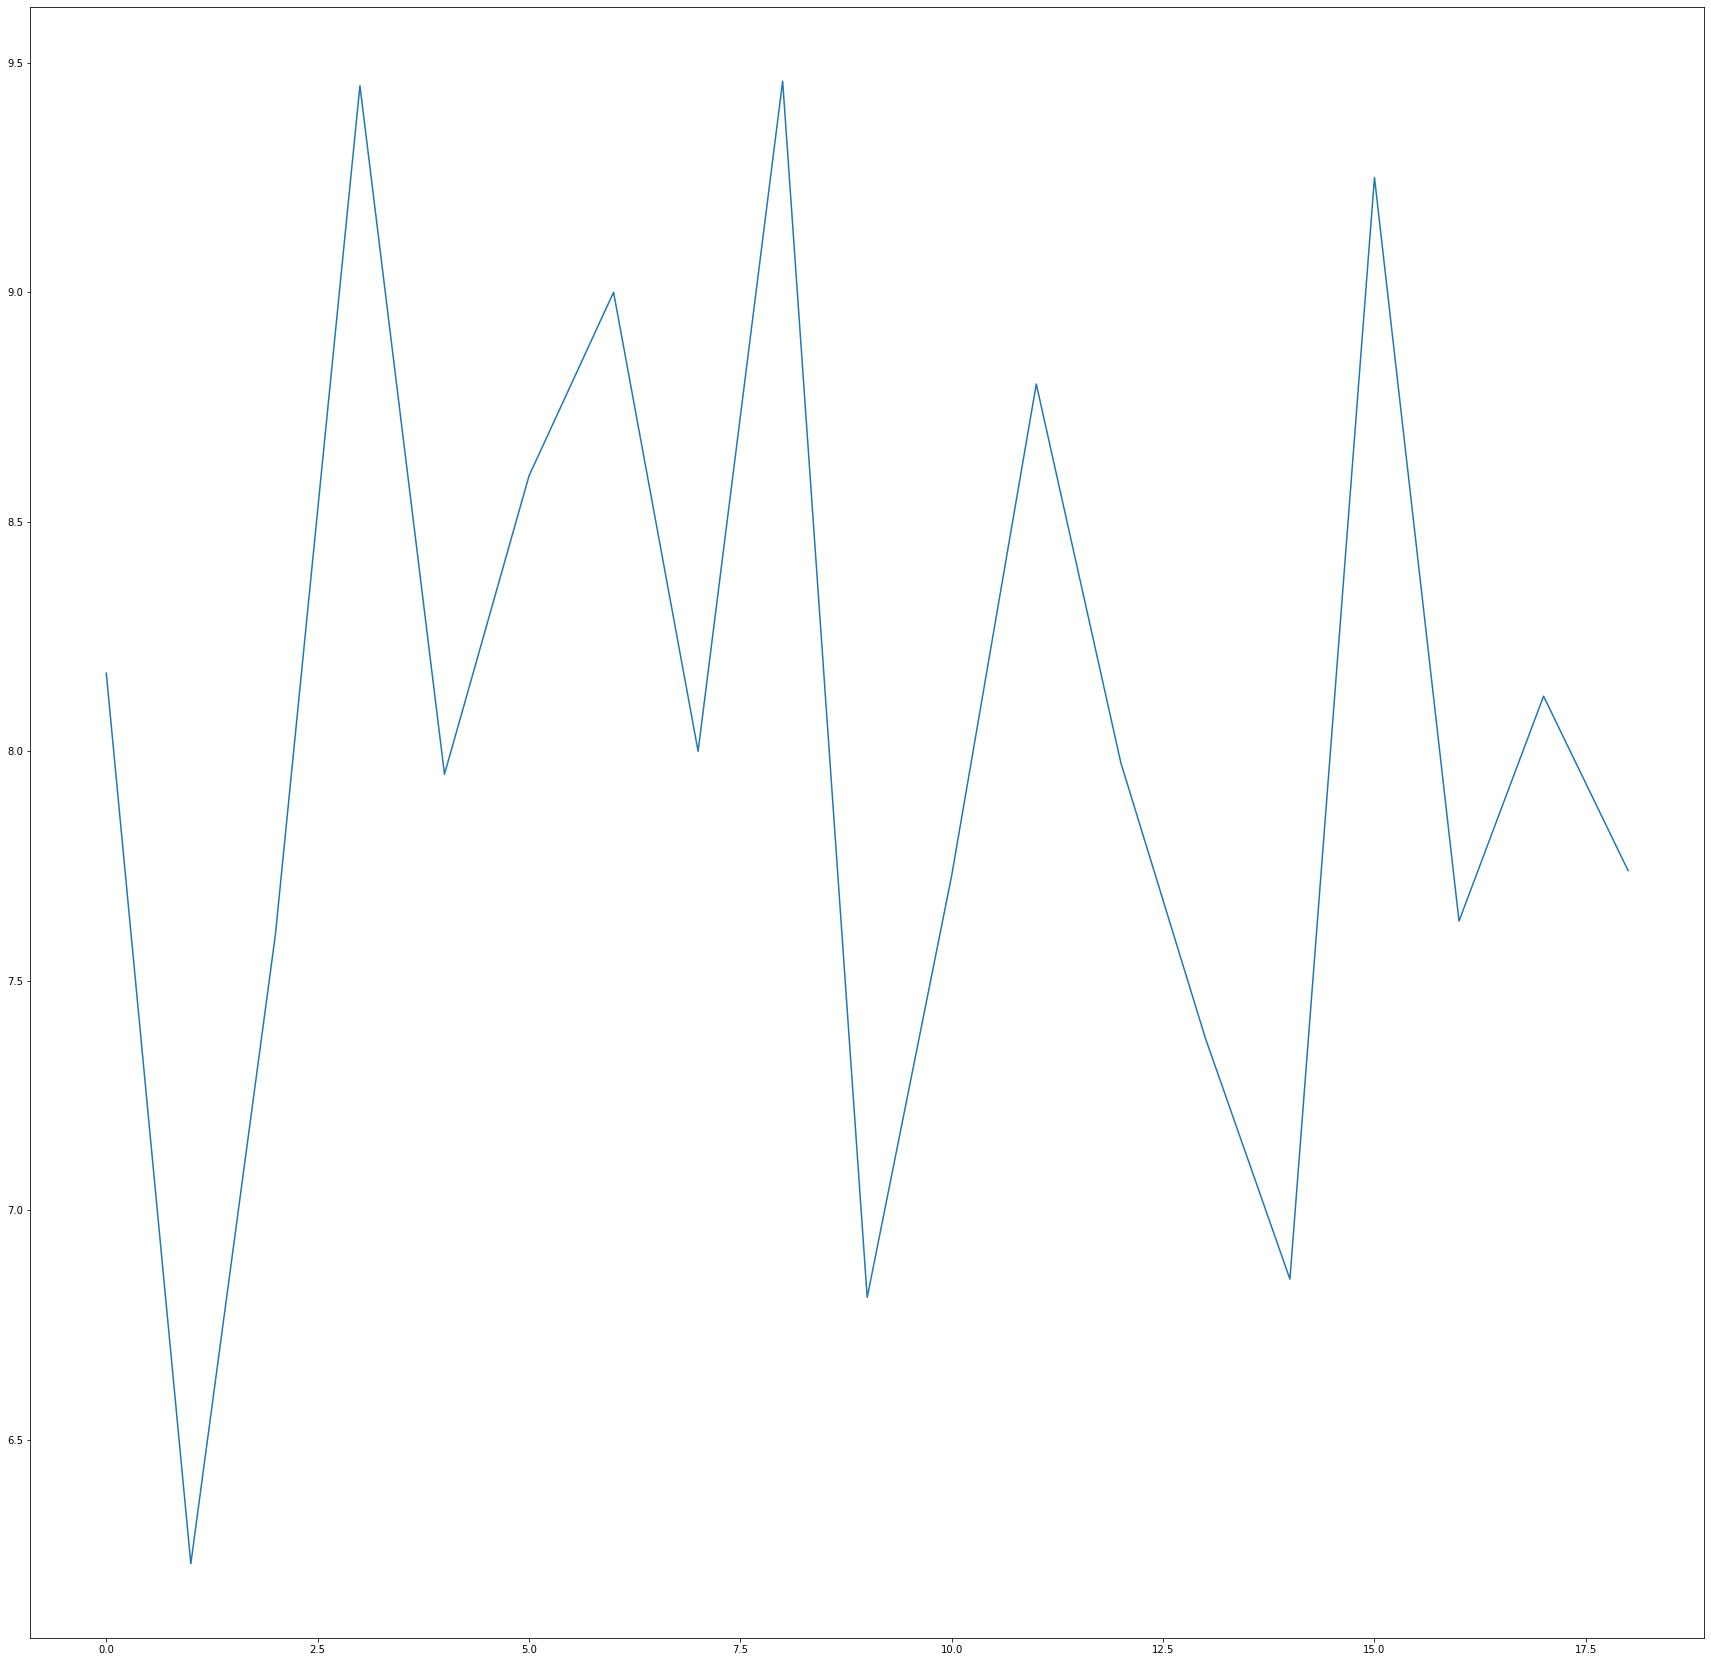

tensor([7.8516, 7.9638, 7.9285, 8.2037, 8.1414], grad_fn=<SelectBackward0>)
max_q_prime tensor(0.0863, grad_fn=<MaxBackward1>)
loss tensor(0.3722, grad_fn=<SmoothL1LossBackward0>)
tensor([8.3125, 8.3676, 8.3203, 8.5829, 8.7011], grad_fn=<SelectBackward0>)
max_q_prime tensor(0.0934, grad_fn=<MaxBackward1>)
loss tensor(0.3602, grad_fn=<SmoothL1LossBackward0>)
tensor([8.6331, 8.6434, 8.5702, 8.8088, 9.0203], grad_fn=<SelectBackward0>)
max_q_prime tensor(0.0972, grad_fn=<MaxBackward1>)
loss tensor(0.4134, grad_fn=<SmoothL1LossBackward0>)
tensor([8.2965, 8.2754, 8.3276, 8.4585, 8.5086], grad_fn=<SelectBackward0>)
max_q_prime tensor(0.0823, grad_fn=<MaxBackward1>)
loss tensor(0.3509, grad_fn=<SmoothL1LossBackward0>)
tensor([8.2605, 8.1810, 8.2971, 8.4410, 8.6044], grad_fn=<SelectBackward0>)
max_q_prime tensor(0.0885, grad_fn=<MaxBackward1>)
loss tensor(0.3446, grad_fn=<SmoothL1LossBackward0>)
tensor([8.3648, 8.1724, 8.3788, 8.3640, 8.6628], grad_fn=<SelectBackward0>)
max_q_prime tensor(0.110

KeyboardInterrupt: 

In [26]:
env = system_manager()
model = actor_network()
target_model = target_network()
reward_history = []
v_history = []

# network topology의 edges(GNN 예제 링크 참고)
adjacency = torch.tensor([[0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4],
                          [1, 2, 0, 2, 3, 0, 1, 3, 4, 1, 2, 4, 2, 3]], dtype=torch.long)
# for each time step
time = 0
episode = 1
epsilon = 1.0
epsilon_decay = 0.97
epoch = 0

target_model.load_state_dict(model.state_dict())

while True:
    epoch += 1
    if epoch % 10 == 9:
        new_epsilon = epsilon * epsilon_decay
        print(new_epsilon)
        if math.floor(new_epsilon) != math.floor(epsilon):
            print(new_epsilon)
            
        epsilon = new_epsilon
        
    if epoch % 1000 == 999:
        target_model.load_state_dict(model.state_dict())
    #print('---------------------------------------------------------------------------')
    node_state, link_state = env.get_state()  # 환경으로부터 실제 state를 관측해 옴(OMNeT++에서 얻어온 statistic로 대체되어야 함).
    node_state = torch.tensor(node_state, dtype=torch.float)
    link_state = torch.tensor(link_state, dtype=torch.float)
    job_waiting_state = env.get_job_waiting_vector()
    
    env.init_job_progress()
    temp_replay_memory = []
    
    # actions through multiple inferences
    scheduled_job_num = 0
    # 시스템에 job이 꽉찼거나, 스케줄할 job이 없거나, 현재 timestep에서 스케줄링한 job 개수가 10개 이상이면 그만한다.
    while env.activated_job_num < 10 and len(env.job_waiting_queue) > 0 and scheduled_job_num < 10:
        # job waiting 제일 앞에 있는 job 가져와서 스케줄링 해야 함.
        job_idx = env.assign_index()
        job = env.job_waiting_queue[0]
        subtasks = job.subtasks
        offloading_vector = []
        
        # 이 job의 모든 subtasks(layers)를 스케줄링해야 함.
        for order in range(len(subtasks)):
            network_state = Data(x=node_state, edge_attr=link_state, edge_index=adjacency)
            prob = model.pi([network_state, torch.tensor(np.array([job_waiting_state]), dtype=torch.float)])
            #print(prob)
            #print(f'prob : {prob}')
            
            if random.random() > epsilon:
                node = torch.argmax(prob[0])
                
            else:
                node = random.randint(0, 4)
            
            #print(f'node : {node}')
            offloading_vector.append(node)
            
            # state transition(환경으로부터 매번 state를 업데이트하는게 아닌, 현재 state를 기반으로 action에 해당하는 waiting만 더해줌).
            # 아래의 구체적인 코드는 이해하시기 보단 OMNeT++에서 받아온 데이터로 새로 짜시는게 빠를 것 같습니다.
            next_node_state = node_state.clone().detach()
            next_job_waiting_state = job_waiting_state.copy()
            
            next_node_state[node][5*job.index+order] += (subtasks[order].comp_demand/100) # 100으로 나누는 이유 : 이렇게 해야 액션이 한쪽 노드로 쏠리게끔 학습이 되는 것을 어느정도 방지할 수 있는 것을 확인.
            # 100으로 안나눠주면 너무 큰 값이 state에 추가되어서 inference시 가중치랑 곱해지면서 액션이 한쪽으로 확 쏠리는 걸로 예상됨.
            next_network_state = Data(x=next_node_state, edge_attr=link_state, edge_index=adjacency)
            next_job_waiting_state[5+order] = 0
            
            #model.put_data([network_state, job_waiting_state, node, 0, next_network_state, next_job_waiting_state, prob[0][node].item(), entropy])
            temp_replay_memory.append([network_state, job_waiting_state, node, 0, next_network_state, next_job_waiting_state])
            
            node_state = next_node_state
            job_waiting_state = next_job_waiting_state
        
        scheduled_job_num += 1
        
        # job을 시스템에 스케줄링.
        env.schedule(job_idx, offloading_vector)
        env.move_job() # backlog에 있는 job을 job waiting vector로 옮기는 것.
        job_waiting_state = env.get_job_waiting_vector()
    
    
    # 이 timestep이 끝날때까지 시간을 흘려줌(제가 만든 환경이므로 이런 코드가 필요합니다. OMNeT++은 그냥 시뮬레이션 하면서 시간이 자동으로 흐르므로 필요없습니다).
    for ms in range(100):
        env.step(time)
        time += 1
        
        if time%20 == 0:
            env.create_job(time)
            env.move_job()
    
    # 이 timestep이 끝나면, 했던 행동에 대한 reward 계산(이 tiemstep 동안 시스템에 있는 job의 진행정도)
    # 지금 보상 계산하는 과정에서 살짝 오류가 있습니다. 보상을 계산하기 전에 이번 timestep에서 어떤 job이 끝나서 없어져 버리면 그 job에 대한 진행정도를 추적할 수 없어서 0이 됩니다.
    # 여기서 보상을 계산하는 부분(즉, job의 진행정도 tracking)이 환경과 좀 관련 있기 때문에, 보상을 어떻게 계산할지를 새로 짜시는게 빠를 것 같습니다.
    per_timestep_reward = env.get_reward()
    #if per_timestep_reward == 0:
    #    per_timestep_reward = 5
    
    #print(f'reward : {per_timestep_reward}')
    if time > 100:
        reward_history.append(per_timestep_reward)
        
    if time % 1000 == 0:
        figure(figsize=(30, 30))
        plt.plot(reward_history)
        plt.show()
    
    for i in range(len(temp_replay_memory)):
        temp_replay_memory[i][3] = per_timestep_reward
        
    model.replay_memory += temp_replay_memory
    model.replay_memory = model.replay_memory[-50000:]
    if time % 1000 == 0:
        model.train_net(target_model)
    
    # 새로운 job을 발생시키는 코드.
    if time%10 == 0:
        env.create_job(time)
        env.move_job()

            

In [ ]:
len(model.replay_memory)

12489

In [ ]:
network_batch, job_waiting, a, r, next_network_batch, next_job_waiting = model.make_batch()

In [ ]:
print(a)

tensor([[4],
        [1],
        [4],
        [1],
        [1],
        [1],
        [3],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [4],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [3],
        [1],
        [1],
        [1],
        [3],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [4]])
